## Vision Tranformer Exploration

- Nama : Rayhan Fatih Gunawan
- NIM  :122140134
- Kelas : RA

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import swin_v2_t, Swin_V2_T_Weights, vit_b_16, ViT_B_16_Weights
from torchvision.transforms import ToTensor, Normalize, Compose
import cv2
import os
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from itertools import cycle
from torchvision import models, transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification, DeiTForImageClassificationWithTeacher



# Set random seed for reproducibility
RANDOM_SEED = 2025
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Utility function for device setup (previously in utils.py)
def check_set_gpu(override=None):
    if override == None:
        if torch.cuda.is_available():
            device = torch.device('cuda')
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
            print(f"Using MPS: {torch.backends.mps.is_available()}")
        else:
            device = torch.device('cpu')
            print(f"Using CPU: {torch.device('cpu')}")
    else:
        device = torch.device(override)
    return device

# Set device
device = check_set_gpu()  # Using the integrated utility function

d:\Vison Tranformer\Vision_Transformer_Exploration\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using CPU: cpu


In [13]:
class MakananIndo(Dataset):
    # ImageNet normalization values
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    def __init__(self,
                 data_dir='IF25-4041-dataset/train',
                 img_size=(224, 224),
                 transform=None,
                 split='train'
                 ):
        
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        self.split = split

        # List all image files
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.image_files.sort()
        
        # Load labels from CSV
        csv_path = os.path.join(os.path.dirname(data_dir), 'train.csv')
        df = pd.read_csv(csv_path)
        self.label_dict = dict(zip(df['filename'], df['label']))
        self.labels = [self.label_dict.get(f, None) for f in self.image_files]
        cleaned = [(img, lbl) for img, lbl in zip(self.image_files, self.labels) if lbl is not None]

        self.image_files, self.labels = zip(*cleaned)
        self.image_files = list(self.image_files)
        self.labels = list(self.labels)
        
        # Create train/val split
        all_data = list(zip(self.image_files, self.labels))
        total_len = len(all_data)
        train_len = int(0.8 * total_len)
        
        indices = list(range(total_len))
        random.shuffle(indices)
        
        if split == 'train':
            self.data = [all_data[i] for i in indices[:train_len]]
        elif split == 'val':
            self.data = [all_data[i] for i in indices[train_len:]]
        else:
            raise ValueError("Split must be 'train' or 'val'")
        
        # Define default transforms
        self.default_transform = Compose([
            ToTensor(),
            Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.data[idx][0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)
        
        label = self.data[idx][1]
        
        return image, label, img_path

# Create helper function for label encoding
def create_label_encoder(dataset):
    """Create a mapping from string labels to numeric indices"""
    all_labels = []
    for i in range(len(dataset)):
        _, label, _ = dataset[i]
        all_labels.append(label)
    
    unique_labels = sorted(list(set(all_labels)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    idx_to_label = {idx: label for idx, label in enumerate(unique_labels)}
    
    return label_to_idx, idx_to_label, unique_labels

In [3]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, label_to_idx):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
        inputs = inputs.to(device)
        
        # Convert string labels to numeric indices
        if isinstance(labels_tuple, (tuple, list)):
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[label] for label in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long).to(device)
        else:
            targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'loss': total_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })
    
    return total_loss/len(dataloader), 100.*correct/total

def validate(model, dataloader, criterion, device, label_to_idx):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
            inputs = inputs.to(device)
            
            # Convert string labels to numeric indices
            if isinstance(labels_tuple, (tuple, list)):
                if isinstance(labels_tuple[0], str):
                    label_indices = [label_to_idx[label] for label in labels_tuple]
                else:
                    label_indices = labels_tuple
                targets = torch.tensor(label_indices, dtype=torch.long).to(device)
            else:
                targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': total_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })
    
    return total_loss/len(dataloader), 100.*correct/total

In [4]:
# Hyperparameters
num_epochs = 14
batch_size = 16
learning_rate = 1e-4
img_size = (224, 224)  

# Create datasets
print("Loading datasets...")
train_dataset = MakananIndo(
    data_dir='IF25-4041-dataset/train',
    img_size=img_size,
    split='train'
)

val_dataset = MakananIndo(
    data_dir='IF25-4041-dataset/train',
    img_size=img_size,
    split='val'
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create label encoder
print("\nCreating label encoder...")
label_to_idx, idx_to_label, unique_labels = create_label_encoder(train_dataset)
num_classes = len(unique_labels)

print(f"Number of classes: {num_classes}")
print(f"Classes: {unique_labels}")
print(f"Label to index mapping: {label_to_idx}")

# Create data loaders
cpu_count = os.cpu_count()
nworkers = cpu_count - 4 if cpu_count > 4 else 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=nworkers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=nworkers,
    pin_memory=True
)

Loading datasets...
Train dataset size: 924
Validation dataset size: 231

Creating label encoder...
Number of classes: 5
Classes: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Label to index mapping: {'bakso': 0, 'gado_gado': 1, 'nasi_goreng': 2, 'rendang': 3, 'soto_ayam': 4}


In [5]:
# Create data loaders with more conservative settings
print("Creating data loaders with conservative settings...")

# Start with minimal workers and no pin_memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Start with single-process loading
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Start with single-process loading
    pin_memory=False
)

# Test batch loading
print("\nTesting batch loading...")
try:
    # Get one batch from the train loader
    sample_batch = next(iter(train_loader))
    images, labels, paths = sample_batch
    print(f"Successfully loaded a batch:")
    print(f"- Batch image shape: {images.shape}")
    print(f"- Batch labels: {labels}")
    print("\nDataLoader configuration successful!")
except Exception as e:
    print(f"Error loading batch: {str(e)}")
    print(f"Full error: {e.__class__.__name__}: {str(e)}")
    raise

Creating data loaders with conservative settings...

Testing batch loading...
Successfully loaded a batch:
- Batch image shape: torch.Size([16, 3, 224, 224])
- Batch labels: ('bakso', 'nasi_goreng', 'nasi_goreng', 'soto_ayam', 'nasi_goreng', 'rendang', 'nasi_goreng', 'rendang', 'nasi_goreng', 'gado_gado', 'soto_ayam', 'nasi_goreng', 'rendang', 'rendang', 'soto_ayam', 'rendang')

DataLoader configuration successful!


In [6]:
# Initialize model
print("\nInitializing Swin Transformer V2 Tiny...")
weights = Swin_V2_T_Weights.IMAGENET1K_V1
model1 = swin_v2_t(weights=weights)

for param in model1.parameters():
    param.requires_grad = False

# ================================================
# UNFREEZE last 2 Swin stages (W2: recommended!)
# ================================================
for param in model1.features[-2:].parameters():
    param.requires_grad = True

print("Unfroze last 2 Swin Transformer stages (best fine-tuning strategy).")

# ================================================
# Replace head
# ================================================
in_features = model1.head.in_features

model1.head = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
)

print(f"Replaced classifier head for {num_classes} classes.")

# Make head trainable
for param in model1.head.parameters():
    param.requires_grad = True

# ================================================
# Move model to device
# ================================================
model1 = model1.to(device)

# ================================================
# Setup optimizer
# ================================================
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model1.parameters()),
    lr=1e-4,                 # IMPORTANT! (lower lr for transformers)
    weight_decay=0.05
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs
)

criterion = nn.CrossEntropyLoss()

# ================================
# 🔍 Check frozen vs trainable parameters
# ================================
total_params = sum(p.numel() for p in model1.parameters())
trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("\n=== Parameter Summary ===")
print(f"Total parameters       : {total_params:,}")
print(f"Trainable parameters   : {trainable_params:,}")
print(f"Frozen parameters      : {frozen_params:,}")

trainable_pct = (trainable_params / total_params) * 100
frozen_pct = 100 - trainable_pct
print(f"Trainable percentage   : {trainable_pct:.2f}%")
print(f"Frozen percentage      : {frozen_pct:.2f}%")

print("\nTrainable layers:")
for name, param in model1.named_parameters():
    if param.requires_grad:
        print(" -", name)

print("\nFrozen layers:")
for name, param in model1.named_parameters():
    if not param.requires_grad:
        print(" -", name)

print("=" * 50)

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model1.head.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print(f"\nTraining setup:")
print(f"- Device: {device}")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: {learning_rate}")
print(f"- Number of epochs: {num_epochs}")
print(f"- Image size: {img_size}")
print(f"- Training classifier only: {sum(p.requires_grad for p in model1.parameters())} trainable tensors")
print("-" * 50)



Initializing Swin Transformer V2 Tiny...
Unfroze last 2 Swin Transformer stages (best fine-tuning strategy).
Replaced classifier head for 5 classes.

=== Parameter Summary ===
Total parameters       : 27,978,863
Trainable parameters   : 15,780,917
Frozen parameters      : 12,197,946
Trainable percentage   : 56.40%
Frozen percentage      : 43.60%

Trainable layers:
 - features.6.reduction.weight
 - features.6.norm.weight
 - features.6.norm.bias
 - features.7.0.norm1.weight
 - features.7.0.norm1.bias
 - features.7.0.attn.logit_scale
 - features.7.0.attn.qkv.weight
 - features.7.0.attn.qkv.bias
 - features.7.0.attn.proj.weight
 - features.7.0.attn.proj.bias
 - features.7.0.attn.cpb_mlp.0.weight
 - features.7.0.attn.cpb_mlp.0.bias
 - features.7.0.attn.cpb_mlp.2.weight
 - features.7.0.norm2.weight
 - features.7.0.norm2.bias
 - features.7.0.mlp.0.weight
 - features.7.0.mlp.0.bias
 - features.7.0.mlp.3.weight
 - features.7.0.mlp.3.bias
 - features.7.1.norm1.weight
 - features.7.1.norm1.bias


In [8]:
# === Initialize ViT B_16 pretrained ===
print("\nInitializing ViT B_16 model...")
weights = ViT_B_16_Weights.IMAGENET1K_V1
model2 = vit_b_16(weights=weights)

# Freeze all parameters first
for param in model2.parameters():
    param.requires_grad = False

# Unfreeze last 2 transformer blocks (ViT blocks in model.encoder.layers)
num_layers = len(model2.encoder.layers)
last_2_layers = model2.encoder.layers[num_layers - 2 :]

for layer in last_2_layers:
    for param in layer.parameters():
        param.requires_grad = True

print("Unfroze last 2 ViT transformer blocks (best fine-tuning strategy).")

# Replace head/classifier
in_features = model2.heads.head.in_features

model2.heads.head = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
)

print(f"Replaced classifier head for {num_classes} classes.")

# Make new head trainable
for param in model2.heads.head.parameters():
    param.requires_grad = True

# Move model to device
model2 = model2.to(device)

# Setup optimizer (only trainable params)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model2.parameters()),
    lr=learning_rate,
    weight_decay=0.05
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

criterion = nn.CrossEntropyLoss()

# Parameter summary
total_params = sum(p.numel() for p in model2.parameters())
trainable_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("\n=== Parameter Summary ===")
print(f"Total parameters       : {total_params:,}")
print(f"Trainable parameters   : {trainable_params:,}")
print(f"Frozen parameters      : {frozen_params:,}")

trainable_pct = (trainable_params / total_params) * 100
print(f"Trainable percentage   : {trainable_pct:.2f}%")
print(f"Frozen percentage      : {100 - trainable_pct:.2f}%")

print("\nTrainable layers:")
for name, param in model2.named_parameters():
    if param.requires_grad:
        print(" -", name)

print("\nFrozen layers:")
for name, param in model2.named_parameters():
    if not param.requires_grad:
        print(" -", name)

print("=" * 50)

print(f"\nTraining setup:")
print(f"- Device: {device}")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: {learning_rate}")
print(f"- Number of epochs: {num_epochs}")
print(f"- Image size: {img_size}")
print(f"- Training classifier + last 2 transformer blocks")
print(f"- Trainable tensors: {sum(p.requires_grad for p in model2.parameters())}")
print("-" * 50)



Initializing ViT B_16 model...
Unfroze last 2 ViT transformer blocks (best fine-tuning strategy).
Replaced classifier head for 5 classes.

=== Parameter Summary ===
Total parameters       : 86,194,949
Trainable parameters   : 14,572,037
Frozen parameters      : 71,622,912
Trainable percentage   : 16.91%
Frozen percentage      : 83.09%

Trainable layers:
 - encoder.layers.encoder_layer_10.ln_1.weight
 - encoder.layers.encoder_layer_10.ln_1.bias
 - encoder.layers.encoder_layer_10.self_attention.in_proj_weight
 - encoder.layers.encoder_layer_10.self_attention.in_proj_bias
 - encoder.layers.encoder_layer_10.self_attention.out_proj.weight
 - encoder.layers.encoder_layer_10.self_attention.out_proj.bias
 - encoder.layers.encoder_layer_10.ln_2.weight
 - encoder.layers.encoder_layer_10.ln_2.bias
 - encoder.layers.encoder_layer_10.mlp.0.weight
 - encoder.layers.encoder_layer_10.mlp.0.bias
 - encoder.layers.encoder_layer_10.mlp.3.weight
 - encoder.layers.encoder_layer_10.mlp.3.bias
 - encoder.la

In [20]:
# Training loop with error handling and early stopping
best_val_acc = 0
patience = 5  # Number of epochs to wait for improvement
counter = 0    # Counter for patience
print("Starting training loop...")

try:
    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch+1}/{num_epochs}')
        
        try:
            # Training
            train_loss, train_acc = train_one_epoch(
                model1, train_loader, criterion, optimizer, device, label_to_idx
            )
            
            # Validation
            val_loss, val_acc = validate(
                model1, val_loader, criterion, device, label_to_idx
            )
            
            scheduler.step()
            
            # Early stopping check
            if val_acc > best_val_acc:
                counter = 0  # Reset counter
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model1_state_dict': model1.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                }, 'best_model1.pth')
                print(f"New best model1 saved! Validation accuracy: {val_acc:.2f}%")
            else:
                counter += 1
                print(f"No improvement for {counter} epochs")
                if counter >= patience:
                    print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
                    break
            
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
            print("-" * 50)
            
        except Exception as e:
            print(f"Error during epoch {epoch+1}: {str(e)}")
            print(f"Full error: {e.__class__.__name__}: {str(e)}")
            raise

except KeyboardInterrupt:
    print("\nTraining interrupted by user")
except Exception as e:
    print(f"\nTraining stopped due to error: {str(e)}")
    print(f"Full error: {e.__class__.__name__}: {str(e)}")
    raise
finally:
    print("\nFinal best validation accuracy:", best_val_acc)

Starting training loop...

Epoch: 1/14


Validation: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it, loss=1.6, acc=21.6] 


New best model1 saved! Validation accuracy: 21.65%
Train Loss: 1.6160 | Train Acc: 20.02%
Val Loss: 1.6027 | Val Acc: 21.65%
--------------------------------------------------

Epoch: 2/14


Validation: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it, loss=1.6, acc=21.6] 


No improvement for 1 epochs
Train Loss: 1.6241 | Train Acc: 19.70%
Val Loss: 1.6027 | Val Acc: 21.65%
--------------------------------------------------

Epoch: 3/14


Validation: 100%|██████████| 15/15 [00:27<00:00,  1.81s/it, loss=1.6, acc=21.6] 


No improvement for 2 epochs
Train Loss: 1.6152 | Train Acc: 18.94%
Val Loss: 1.6027 | Val Acc: 21.65%
--------------------------------------------------

Epoch: 4/14


Validation: 100%|██████████| 15/15 [00:26<00:00,  1.79s/it, loss=1.6, acc=21.6] 


No improvement for 3 epochs
Train Loss: 1.6199 | Train Acc: 17.21%
Val Loss: 1.6027 | Val Acc: 21.65%
--------------------------------------------------

Epoch: 5/14


Validation: 100%|██████████| 15/15 [00:27<00:00,  1.81s/it, loss=1.6, acc=21.6] 


No improvement for 4 epochs
Train Loss: 1.6289 | Train Acc: 19.26%
Val Loss: 1.6027 | Val Acc: 21.65%
--------------------------------------------------

Epoch: 6/14


Validation: 100%|██████████| 15/15 [00:28<00:00,  1.92s/it, loss=1.6, acc=21.6] 

No improvement for 5 epochs

Early stopping triggered! No improvement for 5 epochs.

Final best validation accuracy: 21.645021645021647


In [9]:
# Training loop with error handling and early stopping
best_val_acc = 0
patience = 5  # Number of epochs to wait for improvement
counter = 0    # Counter for patience
print("Starting training loop...")

try:
    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch+1}/{num_epochs}')
        
        try:
            # Training
            train_loss, train_acc = train_one_epoch(
                model2, train_loader, criterion, optimizer, device, label_to_idx
            )
            
            # Validation
            val_loss, val_acc = validate(
                model2, val_loader, criterion, device, label_to_idx
            )
            
            scheduler.step()
            
            # Early stopping check
            if val_acc > best_val_acc:
                counter = 0  # Reset counter
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model2_state_dict': model2.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                }, 'best_model2.pth')
                print(f"New best model2 saved! Validation accuracy: {val_acc:.2f}%")
            else:
                counter += 1
                print(f"No improvement for {counter} epochs")
                if counter >= patience:
                    print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
                    break
            
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
            print("-" * 50)
            
        except Exception as e:
            print(f"Error during epoch {epoch+1}: {str(e)}")
            print(f"Full error: {e.__class__.__name__}: {str(e)}")
            raise

except KeyboardInterrupt:
    print("\nTraining interrupted by user")
except Exception as e:
    print(f"\nTraining stopped due to error: {str(e)}")
    print(f"Full error: {e.__class__.__name__}: {str(e)}")
    raise
finally:
    print("\nFinal best validation accuracy:", best_val_acc)

Starting training loop...

Epoch: 1/14


Validation: 100%|██████████| 15/15 [00:44<00:00,  2.98s/it, loss=0.14, acc=97.8] 


New best model2 saved! Validation accuracy: 97.84%
Train Loss: 0.7380 | Train Acc: 77.71%
Val Loss: 0.1404 | Val Acc: 97.84%
--------------------------------------------------

Epoch: 2/14


Validation: 100%|██████████| 15/15 [00:45<00:00,  3.04s/it, loss=0.0214, acc=100]


New best model2 saved! Validation accuracy: 100.00%
Train Loss: 0.0848 | Train Acc: 98.59%
Val Loss: 0.0214 | Val Acc: 100.00%
--------------------------------------------------

Epoch: 3/14


Validation: 100%|██████████| 15/15 [00:43<00:00,  2.91s/it, loss=0.0196, acc=99.1]


No improvement for 1 epochs
Train Loss: 0.0248 | Train Acc: 99.68%
Val Loss: 0.0196 | Val Acc: 99.13%
--------------------------------------------------

Epoch: 4/14


Validation: 100%|██████████| 15/15 [00:43<00:00,  2.92s/it, loss=0.0242, acc=99.1]


No improvement for 2 epochs
Train Loss: 0.0108 | Train Acc: 99.89%
Val Loss: 0.0242 | Val Acc: 99.13%
--------------------------------------------------

Epoch: 5/14


Validation: 100%|██████████| 15/15 [00:43<00:00,  2.90s/it, loss=0.00989, acc=99.6]


No improvement for 3 epochs
Train Loss: 0.0053 | Train Acc: 100.00%
Val Loss: 0.0099 | Val Acc: 99.57%
--------------------------------------------------

Epoch: 6/14


Validation: 100%|██████████| 15/15 [00:43<00:00,  2.90s/it, loss=0.00921, acc=99.6]


No improvement for 4 epochs
Train Loss: 0.0029 | Train Acc: 100.00%
Val Loss: 0.0092 | Val Acc: 99.57%
--------------------------------------------------

Epoch: 7/14


Validation: 100%|██████████| 15/15 [00:43<00:00,  2.90s/it, loss=0.00761, acc=99.6]

No improvement for 5 epochs

Early stopping triggered! No improvement for 5 epochs.

Final best validation accuracy: 100.0


Preview dataset:


,filename,label
0,0001.jpg,gado_gado
1,0002.jpg,gado_gado
2,0003.jpg,rendang
3,0004.jpg,bakso
4,0005.jpg,bakso



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163 entries, 0 to 1162
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1163 non-null   object
 1   label     1163 non-null   object
dtypes: object(2)
memory usage: 18.3+ KB
None

Distribusi kelas:
label
rendang        238
bakso          235
gado_gado      232
soto_ayam      229
nasi_goreng    229
Name: count, dtype: int64


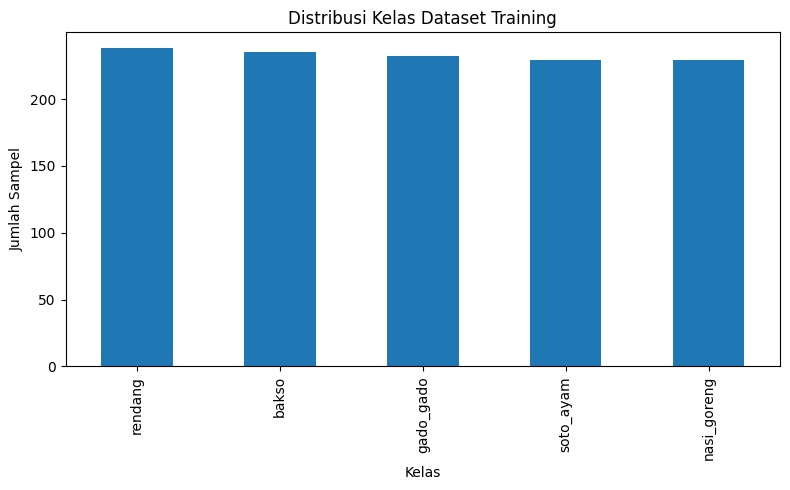

<Figure size 640x480 with 0 Axes>

In [18]:


# Load CSV
csv_path = "IF25-4041-dataset/train.csv"  # ubah sesuai path kamu
df = pd.read_csv(csv_path)

# Tampilkan 5 baris awal
print("Preview dataset:")
display(df.head())

# Info dataset
print("\nInfo dataset:")
print(df.info())

# Cek distribusi kelas
label_col = "label"  # ubah jika kolom berbeda
class_counts = df[label_col].value_counts()
print("\nDistribusi kelas:")
print(class_counts)

# Plot distribusi
plt.figure(figsize=(8, 5))
class_counts.plot(kind="bar")
plt.title("Distribusi Kelas Dataset Training")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.tight_layout()
plt.show()
plt.savefig("Distribusi_data.png")


Preview dataset:


,filename,label
0,gado_gado_1.jpg,gado gado
1,gado_gado_2.jpg,gado gado
2,gado_gado_3.jpg,gado gado
3,gado_gado_4.jpg,gado gado
4,gado_gado_5.jpg,gado gado



Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  97 non-null     object
 1   label     97 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB
None

Distribusi kelas:
label
gado gado      26
soto ayam      23
rendang        23
nasi goreng    13
bakso          12
Name: count, dtype: int64


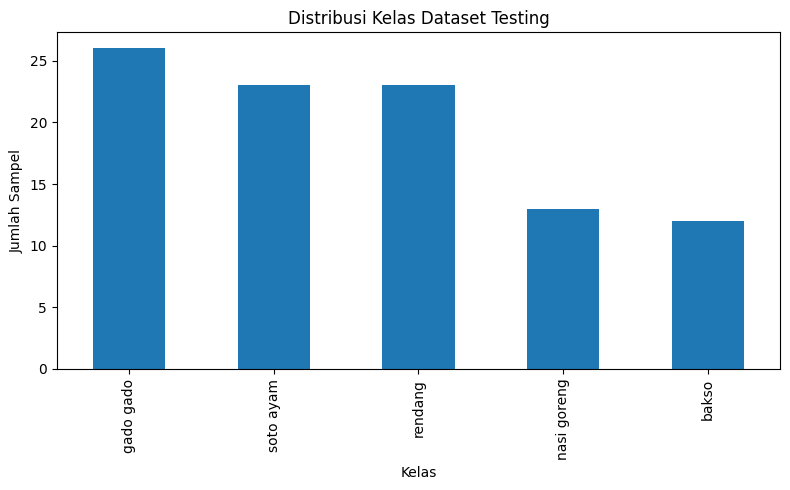

<Figure size 640x480 with 0 Axes>

In [21]:


# Load CSV
csv_path = "./test.csv"  # ubah sesuai path kamu
df = pd.read_csv(csv_path)

# Tampilkan 5 baris awal
print("Preview dataset:")
display(df.head())

# Info dataset
print("\nInfo dataset:")
print(df.info())

# Cek distribusi kelas
label_col = "label"  # ubah jika kolom berbeda
class_counts = df[label_col].value_counts()
print("\nDistribusi kelas:")
print(class_counts)

# Plot distribusi
plt.figure(figsize=(8, 5))
class_counts.plot(kind="bar")
plt.title("Distribusi Kelas Dataset Testing")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.tight_layout()
plt.show()
plt.savefig("Distribusi_data_test.png")
